# AutoComp's Classificator
---

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving traning_data_20180919-152056.csv to traning_data_20180919-152056.csv
User uploaded file "traning_data_20180919-152056.csv" with length 177855 bytes


## Data ingest
---

In [1]:
from sklearn import svm, tree, ensemble, naive_bayes
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
import numpy as np

def ingest(datasetFileName):
    data = pd.read_csv(datasetFileName, header = None)
    data.columns = ["cpu_load", "bandwidth", "bytecounting", "compressor"]
    
    labels_map = {}
    for index, label in np.ndenumerate(data.compressor.unique()):
        labels_map[label] = index[0]
    data["compressor_label"] = data.compressor.map(labels_map)
    data.reset_index(inplace = True)
    data.drop('index', axis = 1, inplace = True)
    print('dataset loaded with shape', data.shape)
    return data, labels_map

data, labels_map = ingest("../../../log/traning_data.csv")
labels = labels_map.keys()
display(data.head())
display(labels_map)
display(labels)

feature_vectors = data[["cpu_load", "bandwidth", "bytecounting"]].values
targets = np.array(data.compressor_label)

x, x_test, y, y_test = train_test_split(feature_vectors,
                                        targets, test_size = 0.05,
                                        stratify = targets,
                                        random_state = 121192)

print(len(x))
print(len(x_test))

dataset loaded with shape (2867, 5)


,cpu_load,bandwidth,bytecounting,compressor,compressor_label
0,0,0,0,zlib_6,0
1,0,0,1,bzip2_9,1
2,0,0,2,zlib_6,0
3,0,0,3,zlib_6,0
4,0,0,4,zlib_6,0


{'bzip2_9': 1, 'copy': 3, 'snappy': 2, 'zlib_6': 0}

dict_keys(['zlib_6', 'bzip2_9', 'snappy', 'copy'])

2723
144


## Iris Dataset
---

In [20]:
from sklearn import svm, tree, ensemble, naive_bayes
from sklearn.model_selection import GridSearchCV, train_test_split
import pandas as pd
import numpy as np
from sklearn import datasets

iris = datasets.load_iris()
data = iris.data
target = iris.target
labels = np.unique(target)

x, x_test, y, y_test = train_test_split(data, target, test_size = 0.1,
                                        stratify = target, random_state = 0)

print(len(x))
print(len(x_test))

142
8


## Classifier fitting
---

In [2]:
def fit(classifier, x, y, x_test = None, y_test = None):
    classifier.fit(x, y)
    train_accuracy = classifier.score(x, y)
    test_accuracy = None
    
    if x_test is not None and y_test is not None:    
        test_accuracy = classifier.score(x_test, y_test)

    return train_accuracy, test_accuracy


## Best Support Vector Machine Function

---

In [3]:
def get_best_svm(x, y):
    parameters = [
        #{
        #    "kernel": ["linear"],
        #    "C": [0.01, 0.1, 1, 10]
        #},
        {
            "kernel": ["rbf"],
        #    "C": [0.01, 0.1, 1, 10],
            "C": [100],
            "gamma": [0.1]
        }
    ]
    grid_search = GridSearchCV(svm.SVC(), parameters, cv = 5, n_jobs = 4,
                               verbose = 3)
    grid_search.fit(x, y)

    best_svm = None

    # Instanciating the best SVM
    if len(grid_search.best_params_) == 2:
        best_svm = svm.SVC(kernel = grid_search.best_params_["kernel"],
                                  C = grid_search.best_params_["C"])
    elif len(grid_search.best_params_) == 3:
        best_svm = svm.SVC(kernel = grid_search.best_params_["kernel"],
                                  C = grid_search.best_params_["C"],
                                  gamma = grid_search.best_params_["gamma"])
    else:
        best_svm = svm.SVC(kernel = grid_search.best_params_["kernel"],
                                  C = grid_search.best_params_["C"],
                                  gamma = grid_search.best_params_["gamma"],
                                  degree = grid_search.best_params_["degree"])
       
    return best_svm, grid_search.best_params_

## Best Decision Tree Function
---

In [6]:
def get_best_decision_tree(x, y):
    parameters = {
        "criterion": ["entropy"],
        "splitter": ["best"],
        "max_depth": [9]
    }
    grid_search = GridSearchCV(tree.DecisionTreeClassifier(random_state = 0),
                               parameters, cv = 5, n_jobs = 8, verbose = 1)
    grid_search.fit(x, y)

    # Instanciating the best decision tree

    best_decision_tree = \
        tree.DecisionTreeClassifier(criterion = grid_search.best_params_["criterion"],
                                    max_depth = grid_search.best_params_["max_depth"],
                                    splitter = grid_search.best_params_["splitter"],
                                    random_state = 0)
    
    return best_decision_tree, grid_search.best_params_

## Best AdaBoost Function
---

In [7]:
def get_best_adaboost(x, y):
    parameters = {
        "base_estimator__criterion": ["gini"],
        "base_estimator__splitter": ["best"],
        "base_estimator__max_depth": [11],
        "n_estimators": [60]
    }

    base_estimator = tree.DecisionTreeClassifier(random_state = 0)
    grid_search = \
        GridSearchCV(ensemble.AdaBoostClassifier(base_estimator = base_estimator,
                                                 random_state = 0),
                     parameters, cv = 5, n_jobs = 8, verbose = 1)
    grid_search.fit(x, y)

    # Instanciating the best AdaBoost

    base_estimator = \
        tree.DecisionTreeClassifier(criterion = grid_search.best_params_["base_estimator__criterion"],
                                    max_depth = grid_search.best_params_["base_estimator__max_depth"],
                                    splitter = grid_search.best_params_["base_estimator__splitter"],
                                    random_state = 0)
    best_adaboost = \
        ensemble.AdaBoostClassifier(base_estimator = base_estimator,
                                    n_estimators = grid_search.best_params_["n_estimators"],
                                    random_state = 0)
    
    return best_adaboost, grid_search.best_params_

## Best Random Forest Function
---

In [7]:
def get_best_random_forest(x, y):
    parameters = { 
        "n_estimators": [5, 10, 30, 50, 60],
        "max_depth": [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30, 40, 50, None],
        "criterion":['gini', 'entropy']
    }

    grid_search = \
        GridSearchCV(ensemble.RandomForestClassifier(n_jobs = 8, random_state = 0),
                     parameters, cv = 5, n_jobs = 8, verbose = 1)
    grid_search.fit(x, y)

    # Instanciating the best random forest

    best_random_forest = \
        ensemble.RandomForestClassifier(criterion = grid_search.best_params_["criterion"],
                                        max_depth = grid_search.best_params_["max_depth"],
                                        n_estimators = grid_search.best_params_["n_estimators"],
                                        random_state = 0)
    
    return best_random_forest, grid_search.best_params_

## Best Multinomial Naive Bayes
---

In [8]:
def get_best_multinomialnb(x, y):
    parameters = { 
        "alpha": [0.1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    }

    grid_search = \
        GridSearchCV(naive_bayes.MultinomialNB(), parameters, cv = 5,
                     n_jobs = 8, verbose = 1)
    grid_search.fit(x, y)

    # Instanciating the best multinomial NB

    best_multinomianb = \
        naive_bayes.MultinomialNB(alpha = grid_search.best_params_["alpha"])
    
    return best_multinomianb, grid_search.best_params_

## Best classifiers
---

### SVM

In [9]:
# Best SVM #####################################################################

print("-----------------------------------------------------------------------")
print("--> Searching best hyperparameters for SVM:\n")

best_svm, svm_best_parameters = get_best_svm(x, y)

print("\nDone:", svm_best_parameters)
print("-----------------------------------------------------------------------")

################################################################################

-----------------------------------------------------------------------
--> Searching best hyperparameters for SVM:

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV]  C=100, gamma=0.1, kernel=rbf, score=0.8278388278388278, total=   1.5s
[CV]  C=100, gamma=0.1, kernel=rbf, score=0.8311926605504587, total=   1.4s
[CV] C=100, gamma=0.1, kernel=rbf ....................................
[CV]  C=100, gamma=0.1, kernel=rbf, score=0.8379373848987108, total=   1.5s


[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s


[CV]  C=100, gamma=0.1, kernel=rbf, score=0.8095238095238095, total=   1.7s
[CV]  C=100, gamma=0.1, kernel=rbf, score=0.8158379373848987, total=   1.0s


[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.0s finished



Done: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
-----------------------------------------------------------------------


### Decision Tree

In [10]:
# Best Decision Tree ###########################################################

print("\n")
print("-----------------------------------------------------------------------")
print("--> Searching best hyperparameters for decision tree:\n")

best_decision_tree, dt_best_parameters = get_best_decision_tree(x, y)

print("\n   Done:", dt_best_parameters)
print("-----------------------------------------------------------------------")

################################################################################



-----------------------------------------------------------------------
--> Searching best hyperparameters for decision tree:

Fitting 5 folds for each of 1 candidates, totalling 5 fits

   Done: {'criterion': 'entropy', 'max_depth': 9, 'splitter': 'best'}
-----------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    0.1s finished


### AdaBoost

In [11]:
# Best AdaBoost ################################################################

print("\n")
print("-----------------------------------------------------------------------")
print("--> Searching best hyperparameters for AdaBoost:\n")

best_adaboost, ab_best_parameters = get_best_adaboost(x, y)

print("\n   Done:", ab_best_parameters)
print("-----------------------------------------------------------------------")

################################################################################



-----------------------------------------------------------------------
--> Searching best hyperparameters for AdaBoost:

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=8)]: Done   2 out of   5 | elapsed:    1.4s remaining:    2.1s
[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:    1.5s finished



   Done: {'base_estimator__criterion': 'gini', 'base_estimator__max_depth': 11, 'base_estimator__splitter': 'best', 'n_estimators': 60}
-----------------------------------------------------------------------


### Random Forest

In [11]:
# Best Random Forest ###########################################################

print("\n")
print("-----------------------------------------------------------------------")
print("--> Searching best hyperparameters for random forest:\n")

best_random_forest, rf_best_parameters = get_best_random_forest(x, y)

train_accuracy, test_accuracy = fit(best_random_forest, x, y, x_test, y_test)

print("\n   Done:", rf_best_parameters)
print("Train accuracy:", train_accuracy)
print("Test accuracy:", test_accuracy)
print("-----------------------------------------------------------------------")

plot_confusion_matrix(best_random_forest, x_test, y_test, labels)

################################################################################



-----------------------------------------------------------------------
--> Searching best hyperparameters for random forest:

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.3s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:   49.7s
[Parallel(n_jobs=8)]: Done 750 out of 750 | elapsed:  1.8min finished



   Done: {'criterion': 'entropy', 'max_depth': 15, 'n_estimators': 60}
Train accuracy: 0.884968429989
Test accuracy: 0.549403341289
-----------------------------------------------------------------------


NameError: name 'plot_confusion_matrix' is not defined

### Multinomial Naive Bayes

In [12]:
# Best Multinomial Naive Bayes #################################################

print("\n")
print("-----------------------------------------------------------------------")
print("--> Searching best hyperparameters for random forest:\n")

best_multinomialnb, mnb_best_parameters = get_best_multinomialnb(x, y)

print("\n   Done:", mnb_best_parameters)
print("-----------------------------------------------------------------------")

################################################################################



-----------------------------------------------------------------------
--> Searching best hyperparameters for random forest:

Fitting 5 folds for each of 11 candidates, totalling 55 fits

   Done: {'alpha': 0.1}
-----------------------------------------------------------------------


[Parallel(n_jobs=8)]: Done  40 out of  55 | elapsed:    0.5s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  55 out of  55 | elapsed:    0.5s finished


## Plotting Confusion Matrices
---

Traning SVM:
   Train accuracy:  0.9294895336026442
   Test accuracy:  0.8541666666666666

Traning Decision Tree:
   Train accuracy:  0.9140653690782226
   Test accuracy:  0.8472222222222222

Traning AdaBoost:
   Train accuracy:  1.0
   Test accuracy:  0.8541666666666666

Traning Multinomial Naive Bayes:
   Train accuracy:  0.6929856775615131
   Test accuracy:  0.6875



Text(0.5,1,'Bayesiano ingenuo multinomial')

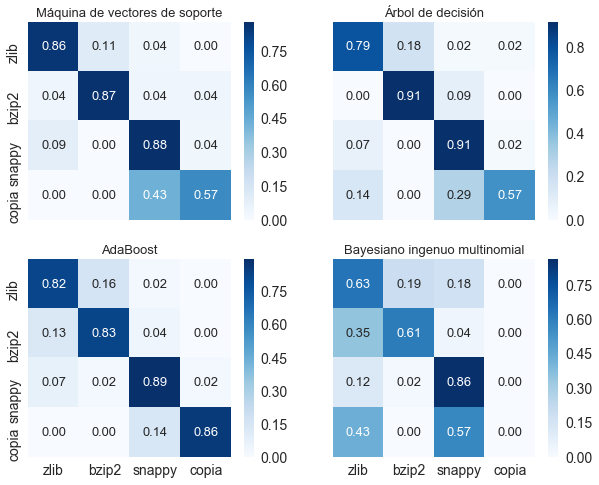

In [23]:
from sklearn import metrics
import matplotlib.pyplot as plot
import seaborn as sn

plot.rcParams['backend'] = "Qt4Agg"

def prepare_subplots(n, m):
    plot.close()
    fig, axes = plot.subplots(n, m, figsize = (10, 8), squeeze = False,
                              sharex = True, sharey = True)
    
    return axes.flatten()

def plot_confusion_matrix(classifier, x, y, labels, ax, normalize = True):
    predictions = classifier.predict(x)
    confusion_matrix = metrics.confusion_matrix(y, predictions)
    
    if normalize:
        confusion_matrix = confusion_matrix.astype("float") / \
                                confusion_matrix.sum(axis = 1)[:, np.newaxis]

    confusion_matrix_frame = pd.DataFrame(confusion_matrix, labels, labels)
    plot.figure(figsize = (10, 7))
    sn.set(font_scale = 1.4)
    sn.heatmap(confusion_matrix_frame, ax = ax, annot = True,
               annot_kws = {"size": 13}, cmap = "Blues",
               fmt = "g" if not normalize else ".2f")


print("Traning SVM:")
svm_train_accuracy, svm_test_accuracy = fit(best_svm, x, y, x_test, y_test)
print("   Train accuracy: ", svm_train_accuracy)
print("   Test accuracy: ", svm_test_accuracy)
print("")


print("Traning Decision Tree:")
dt_train_accuracy, dt_test_accuracy = fit(best_decision_tree, x, y, x_test, y_test)
print("   Train accuracy: ", dt_train_accuracy)
print("   Test accuracy: ", dt_test_accuracy)
print("")


print("Traning AdaBoost:")
ab_train_accuracy, ab_test_accuracy = fit(best_adaboost, x, y, x_test, y_test)
print("   Train accuracy: ", ab_train_accuracy)
print("   Test accuracy: ", ab_test_accuracy)
print("")

print("Traning Multinomial Naive Bayes:")
mnb_train_accuracy, mnb_test_accuracy = fit(best_multinomialnb, x, y, x_test, y_test)
print("   Train accuracy: ", mnb_train_accuracy)
print("   Test accuracy: ", mnb_test_accuracy)
print("")

cf_labels = [label.split("_")[0] for label in labels]
cf_labels = [label if label != "copy" else "copia"
             for label in cf_labels]

axes = prepare_subplots(2, 2)
plot_confusion_matrix(best_svm, x_test, y_test, cf_labels, axes[0])
plot_confusion_matrix(best_decision_tree, x_test, y_test, cf_labels, axes[1])
plot_confusion_matrix(best_adaboost, x_test, y_test, cf_labels, axes[2])
plot_confusion_matrix(best_multinomialnb, x_test, y_test, cf_labels, axes[3])

axes[0].set_title("Máquina de vectores de soporte", fontsize = 13)
axes[1].set_title("Árbol de decisión", fontsize = 13)
axes[2].set_title("AdaBoost", fontsize = 13)
axes[3].set_title("Bayesiano ingenuo multinomial", fontsize = 13)

## Training decision tree with whole data
___

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'splitter': 'random'}
Train accuracy:  0.803627485176
Test accuracy:  None


[Parallel(n_jobs=8)]: Done 300 out of 300 | elapsed:    0.2s finished


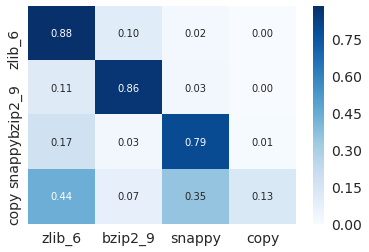

In [9]:
decision_tree, best_parameters = get_best_decision_tree(feature_vectors, targets)
print("Best parameters:", best_parameters)

train_accuracy, test_accuracy = fit(decision_tree, feature_vectors, targets)
print("Train accuracy: ", train_accuracy)
print("Test accuracy: ", test_accuracy)

plot.close()
plot_confusion_matrix(decision_tree, feature_vectors, targets, labels, plot.gca(), True)

## Saving decision tree classifier
---

In [20]:
import csv

def save_decision_tree(decision_tree, filename, labels = []):
    node_info = zip(decision_tree.tree_.children_left,
                    decision_tree.tree_.children_right,
                    decision_tree.tree_.feature,
                    decision_tree.tree_.threshold,
                    [probabilities.argmax()
                     for probabilities in decision_tree.tree_.value])
    node_info = list(node_info)
    
    features = np.unique(decision_tree.tree_.feature)
    null_feature_index = np.where(features == tree._tree.TREE_UNDEFINED)
    n_features = len(np.delete(features, null_feature_index))
    
    with open(filename, "w") as file:
        writer = csv.writer(file, delimiter = " ");
        writer.writerow([len(labels)])
        writer.writerow(labels)
        writer.writerow([n_features])
        writer.writerow([decision_tree.tree_.node_count])
        writer.writerows(node_info)
        
#dt_train_accuracy, dt_test_accuracy = fit(best_decision_tree, x, y, x_test, y_test)
save_decision_tree(best_decision_tree, "../../../models/decision_tree.txt", labels)